In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fftpack import fft
from scipy.signal import get_window

Exercise 1

In [126]:
def spectral_values():
    # Compute the Fourier Transform of the signal

    bearing_data = pd.read_csv('0.csv', delimiter=';')
    signal = bearing_data['b4x'].to_numpy()
    # Fourier Transform
    fft_data = np.fft.fft(bearing_data)

    # Power spectral density
    psd = np.abs(fft_data)**2

    # Spectral centroid
    centroid = np.average(np.real(fft_data), weights=psd)

    # Spectral flatness
    flatness = np.exp(np.mean(np.log(psd))) / np.mean(psd)
    
    print(centroid, flatness)

spectral_values()


-0.30738244579260976 0.0


C:\Users\anjel\AppData\Local\Temp\ipykernel_11792\2552968646.py:16: RuntimeWarning: divide by zero encountered in log
  flatness = np.exp(np.mean(np.log(psd))) / np.mean(psd)


In [110]:
def acceleration_bearing_data(csv_data, x_or_y_direction=False, index=False):
    bearing_data = pd.read_csv(csv_data, delimiter=';')
    bearing_data['x_velocity'] = bearing_data['b4x'].diff()
    bearing_data['x_acceleration'] = bearing_data['x_velocity'].diff()
    bearing_data['y_velocity'] = bearing_data['b4y'].diff()
    bearing_data['y_acceleration'] = bearing_data['y_velocity'].diff()
    bearing_data = bearing_data.dropna()

    if not index:    
        return bearing_data
    
    # Make a function that, given an index, loads the corresponding sample and returns mean, standard deviation,
    # and root mean squared of both x and y acceleration.
    elif x_or_y_direction and index:
        if x_or_y_direction == 'x':
            print('Corresponding Sample:', bearing_data.loc[index, 'b4x'])
        elif x_or_y_direction == 'y':
            print('Corresponding Sample:', bearing_data.loc[index, 'b4y'])

        bearing_data['rms_x'] = np.sqrt(np.mean(bearing_data.x_acceleration**2))
        bearing_data['rms_y'] = np.sqrt(np.mean(bearing_data.y_acceleration**2))

        bearing_data['spectral_centroids'] = bearing_data['b4x'].apply(lambda x: spectral_centroid(x, -0.09))
        
        print('Mean of X-acceleration:', bearing_data.x_acceleration.mean())
        print('Mean of Y-acceleration:', bearing_data.y_acceleration.mean())
    
        print('Stdev of X-acceleration:', bearing_data.x_acceleration.std())
        print('Stdev of Y-acceleration:', bearing_data.y_acceleration.std())
        
        print('RMS of X-acceleration:', bearing_data.loc[index, 'rms_x'])
        print('RMS of Y-acceleration:', bearing_data.loc[index, 'rms_y'])


In [111]:
acceleration_bearing_data('0.csv', x_or_y_direction='x', index=10)

Corresponding Sample: -0.09


IndexError: tuple index out of range

In [59]:
# To simplify the visualization, we made a function.
def viz_acceleration_bearing_data(csv_data):
    bearing_data = acceleration_bearing_data(csv_data)
    y0 = bearing_data.x_acceleration
    X = bearing_data.index

    plt.figure(figsize=(10, 5))
    plt.xlabel('Time (s)')
    plt.ylabel('Acceleration (m/s^2)')
    plt.title(f'Acceleration in x-direction of Bearing 4 (Source = {csv_data})')
    plt.scatter(X, y0)

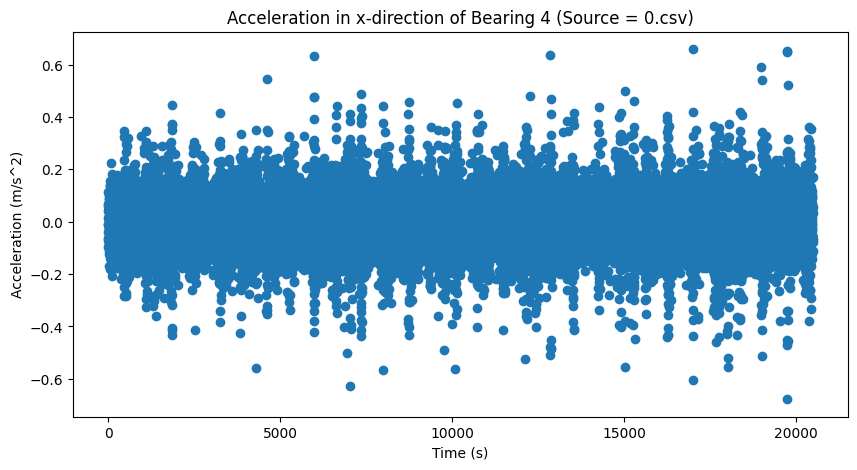

In [60]:
# Load the first sample (0.txt) and visualize the acceleration in the x direction of bearing 4. 
viz_acceleration_bearing_data('0.csv')

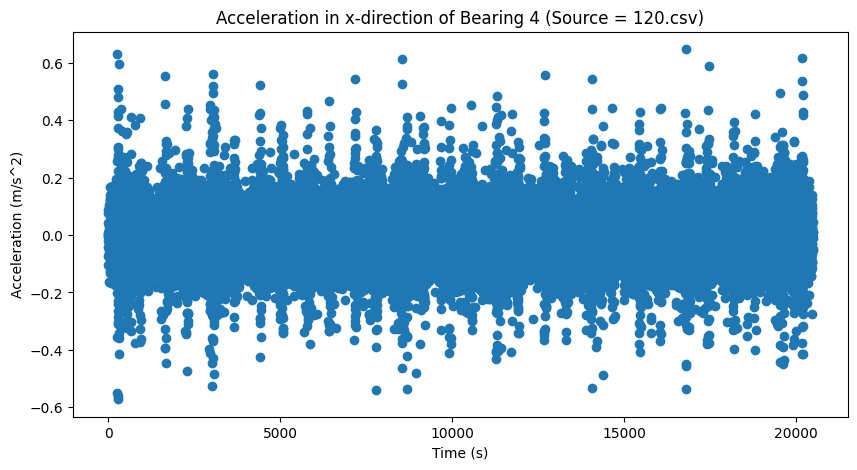

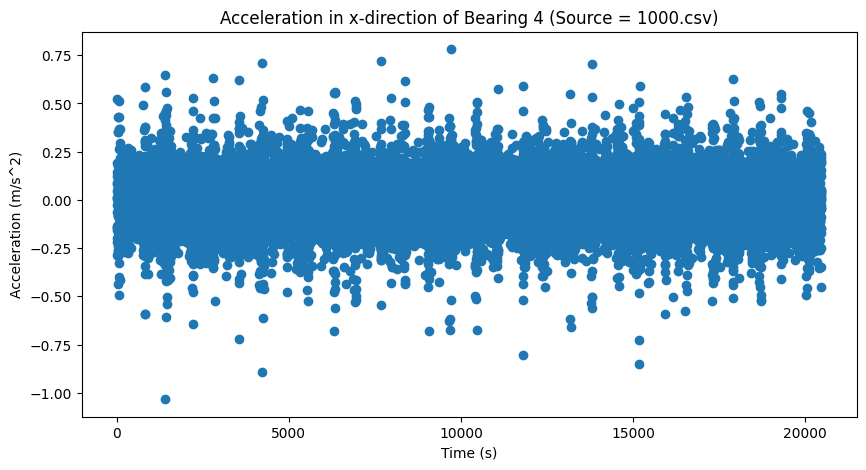

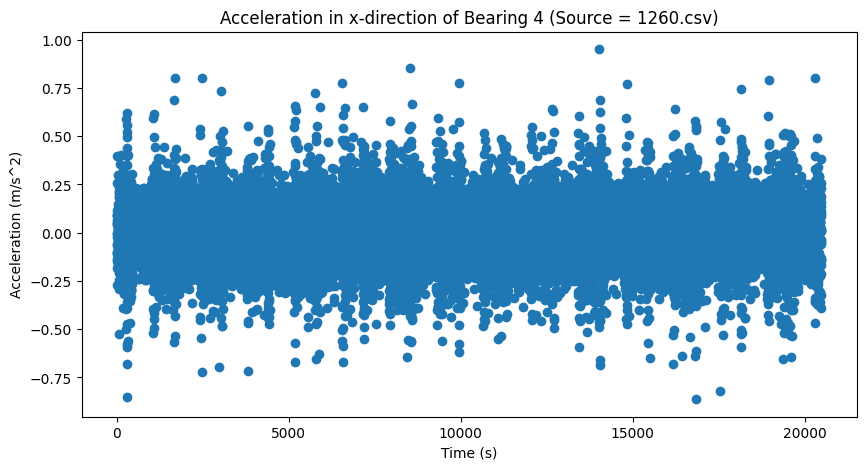

In [61]:
# Compare this visualization to 3 other samples from different degradation stages.
viz_acceleration_bearing_data('120.csv')
plt.show()
viz_acceleration_bearing_data('1000.csv')
plt.show()
viz_acceleration_bearing_data('1260.csv')

KeyError: 1